Studend: Nozomu Nakanishi
Student Id: 2020264
Github:
CA 2 - Big Data / Advanced Data Analytics - 17/11/23

- Importing the necessary libraries for the practical part.

In [2]:
from pyspark.sql import SparkSession
import sparknlp
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.functions import to_date, to_timestamp
from pyspark.sql import functions as F
from pyspark.sql.functions import col, explode, expr, lit, regexp_replace, lower, split, size, length
from pyspark import StorageLevel
import pandas as pd
import matplotlib.pyplot as plt

### Initializing Spark sessiong and Importing the dataset ProjectTweets.

In [3]:
# Initialize Spark Session with recommended settings for Spark NLP
spark = SparkSession.builder \
    .appName("ProjectTweets") \
    .master("local[*]") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.4") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryo.registrator", "com.johnsnowlabs.nlp.serialization.SparkNLPKryoRegistrator") \
    .getOrCreate()

In [4]:
# Defines the schema of the CSV file (ProjectTweets.csv) and adjust the field names and types for the dataframe.
tweetSchema = StructType([
    StructField("sequence", IntegerType(), True),
    StructField("ids", StringType(), True),
    StructField("date", StringType(), True),
    StructField("flag", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True),
])

# Imports the dataset in csv format.
df = spark.read.csv("file:///home/hduser/Desktop/CA2/ProjectTweets.csv", header=False, schema=tweetSchema)

In [5]:
df.show(5, truncate=False)

+--------+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|sequence|ids       |date                        |flag    |user           |text                                                                                                               |
+--------+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|0       |1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
|1       |1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY|scotthamilton  |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |
|2       |1467810917|Mon Apr 06 22:19:53

In [6]:
# Number of rows
num_rows = df.count()

# Number of columns
num_columns = len(df.columns)

# Print out the shape
print(f"The DataFrame shape is: ({num_rows}, {num_columns})")

The DataFrame shape is: (1600000, 6)


- As presented in the .show, the dataframe called df has 6 columns and 1.6 millions of observations. 

In [7]:
# Prints the df schema. 
df.printSchema()

# Which shows that the types of the data are ones set in previous steps.

root
 |-- sequence: integer (nullable = true)
 |-- ids: string (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



- It was observable that the dates have a pacific day time (PDT) and the present notebook it has a different time zone, thus setting the time zone to PDT.

In [8]:
# Sets the time zone to PDT, the same as the date column.
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark.conf.set("spark.sql.session.timeZone", "America/Los_Angeles")

In [9]:
# Creating a new column where the date has a format that is better to perform analysis and models.
# Features like the day of the week and time zone are not necessary. 
date_format = "EEE MMM dd HH:mm:ss zzz yyyy"
# Parses the date e creates a new column dates with a shorter format, but with the necessary data. 
df = df.withColumn("dates", from_unixtime(unix_timestamp("date", date_format)))
df.show()

+--------+----------+--------------------+--------+---------------+--------------------+-------------------+
|sequence|       ids|                date|    flag|           user|                text|              dates|
+--------+----------+--------------------+--------+---------------+--------------------+-------------------+
|       0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|2009-04-06 22:19:45|
|       1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|2009-04-06 22:19:49|
|       2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|2009-04-06 22:19:53|
|       3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|2009-04-06 22:19:57|
|       4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|2009-04-06 22:19:57|
|       5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|2009-04-06 22:20:00|
|       6|146781159

### MISSING VALUES (TEXT COLUMN) AND DUPLICATES (TWITTER ID)

- The missing values will be searched through the tweets column, since the first objective is to extract the sentiment. 
- The duplicates will be searched through the twitter Id column, since is a unique identifier for each tweet, any duplicates will be further removed. 

In [10]:
# Find the count of missing values in the 'text' column
missing_values_count = df.filter(df.text.isNull()).count()
print(f"Number of missing values in 'text' column: {missing_values_count}")

# To find duplicates based on the 'ids' column
duplicates_count = df.groupBy('ids').count().filter("`count` > 1").count()
print(f"Number of duplicate ids: {duplicates_count}")

Number of missing values in 'text' column: 0


Number of duplicate ids: 1685


In [11]:
# To find duplicates based on the 'ids' column
duplicates_count = df.groupBy('ids').count().filter("`count` > 1").count()
print(f"Number of duplicate ids: {duplicates_count}")

Number of duplicate ids: 1685


In [12]:
df = df.dropDuplicates(['ids'])

# Now you can check the count of the DataFrame to ensure duplicates have been removed.
print(f"Count after dropping duplicates: {df.count()}")

Count after dropping duplicates: 1598315


- No presence of empty cells in the dataframe, however 1685 duplicates were found and removed. Reducing the number of observations to 1,598,315.

- Next step will drop columns that do not have purpose in the analysis and extraction.

In [13]:
df = df.drop("date", "ids", "user", "flag")
df.show()

+--------+--------------------+-------------------+
|sequence|                text|              dates|
+--------+--------------------+-------------------+
|       0|@switchfoot http:...|2009-04-06 22:19:45|
|       1|is upset that he ...|2009-04-06 22:19:49|
|       3|my whole body fee...|2009-04-06 22:19:57|
|       6|         Need a hug |2009-04-06 22:20:03|
|       8|@Tatiana_K nope t...|2009-04-06 22:20:05|
|       9|@twittera que me ...|2009-04-06 22:20:09|
|      12|@caregiving I cou...|2009-04-06 22:20:19|
|      15|@iamjazzyfizzle I...|2009-04-06 22:20:20|
|      18|@LettyA ahh ive a...|2009-04-06 22:20:31|
|      20|@alydesigns i was...|2009-04-06 22:20:37|
|      21|one of my friend ...|2009-04-06 22:20:38|
|      29|Meh... Almost Lov...|2009-04-06 22:21:04|
|      31|@alielayus I want...|2009-04-06 22:21:07|
|      33|@julieebaby awe i...|2009-04-06 22:21:11|
|      34|@HumpNinja I cry ...|2009-04-06 22:21:21|
|      35|ok I'm sick and s...|2009-04-06 22:21:20|
|      36|@c

- The column sequence was kept because it contains the original sequence of the dataframe, so in case of any shuffling the original sequence can be called. 

- Next stage will be performed the pre-processing of the tweets.  

# Pre-processing of the tweets and sentiment extraction.

- This step is separeted by two main lines of code, the first will normalized the tweets, by removing url, tags, mentions and character which has no meaning in sentiment extraction. The second is a pipeline from sparkNLP to generate and extract data that it is required to sentiment analysis over time and forecasting. 

- Both of the approaches will attempt to leverage the potential of Spark tools, such as the regex and the Natural Language Processing (NLP) tool, where it has numerous options from the simplest detection to deep learning. 

In [14]:
# Remove URLs
df = df.withColumn("text", F.regexp_replace(F.col("text"), "http(s)?://[^\\s]+", ""))

# Remove HTML tags
df = df.withColumn("text", F.regexp_replace(F.col("text"), "<[^>]+>", ""))

# Remove mentions (i.e., @username)
df = df.withColumn("text", F.regexp_replace(F.col("text"), "@\\w+", ""))

# Convert to lowercase
df = df.withColumn('text', lower(df['text']))

# Remove numbers from the "text" column
df = df.withColumn('text', regexp_replace(df['text'], r'\d+', ''))

# Reduce excessive characters (more than two of the same in a row)
df = df.withColumn('text', regexp_replace('text', r'(.)\1{2,}', r'\1\1'))

# Remove punctuation
df = df.withColumn('text', regexp_replace(df['text'], r"[^\w\s]", ""))

df.select("text").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                         |
+-----------------------------------------------------------------------------------------------------------------------------+
|   a11 thats a bummer  you shoulda got david carr of third day to do it d                                                    |
|is upset that he cant update his facebook by texting it11 and might cry as a result  school today also blah                  |
| i dived many times for the ball managed to save   the rest go out of bounds                                                 |
|my whole body feels itchy and like its on fire                                                                               |
|need a hug                                                                                             

In [15]:
# Counts the entries with URLs.
url_count = df.filter(F.col("text").rlike("http(s)?://([\\w-]+\\.)+[\\w-]+(/[\\w- ./?%&=]*)?")).count()

# Counts the entries with HTML tags.
html_tags_count = df.filter(F.col("text").rlike("<[^>]+>")).count()

# Counts the entries with mentions (@username).
mentions_count = df.filter(F.col("text").rlike("@\\w+")).count()

print(f"Number of entries with URLs: {url_count}")
print(f"Number of entries with HTML tags: {html_tags_count}")
print(f"Number of entries with mentions: {mentions_count}")

Number of entries with URLs: 0
Number of entries with HTML tags: 0
Number of entries with mentions: 0


In [16]:
# Find the count of missing values in the 'text' column
missing_values_count = df.filter(df.text.isNull()).count()
print(f"Number of missing values in 'text' column: {missing_values_count}")

Number of missing values in 'text' column: 0


The last few lines of code shows that: 
- The final format is satisfatory to apply NLP techniques; 
- No mentions, tags, html were found after normalization;
- Also, no missing values were generated by the regex; 

### Natural Language Processing with SparkNLP library. 

The library chosen is based on a few factors. First, to extract the semtiment VADER approach , which is considered to be appropriate for social media content was attempt. However, erros related to out of memory and serialization led to the discard of the technique. And with many other options sparkNLP presented to be a good option, for memory efficiency and richness of NLP tasks. 
Overvall the choice of the library relies on: 
- It was built on top of Spark, thus is highly scalable and it is an appropriate choice for big dataframes, which is the case of this project, with more than a million tweets.
- It possess a vast number of operations, from the simplest to neural networks. The operations that are necessary to extract the data required can be achieved with only one library (memory effiency and consistency during transformations). 
- Pipeline, tasks can be perfomed with an optimized workflows through pipelines, reducing the number of codes to be called. 
- Pre-trained models, the library has models that are trained already that can be applied to other dataframes, in case of this project, to detect the language, spell checker, word embeddings and sentiment extraction techniques will be used. 

The codes and usage for the techniques and models were obtain through the SparkNLP documentation / annotadors. <br>
1.  https://sparknlp.org/docs/en/concepts <br>
2.  https://sparknlp.org/docs/en/annotators

The pipeline is composed by eight operations: 

1. The first is to transform the tweets into a document format that is going to be required in the next stages;

2. Not only to maintain the original context, many other operations in the pipeline needs the text at a sentence level to perform at best, in the present case, the tokenizer onwards is mainly using this format;

- Language detector using a pre-trained model was performed, however it did not yield good results, removing the code from the pipeline.

3. Tokenization of the tweets, the next techniques required that the text inputs are separeted;

4. In social media content is known to have many type of misspellings and the sparkNLP provides a few options to correct it <b>(1)</b>. The pre-trained chosen model is NorvigSweeting model, although the choice was made due to memory constrains.<b>(2)</b> 
- The first pre-trained approach attempted was the Context Spell Checker, a noisy channel model spell algorithm. However, the machine used for project resulted in running of out memory, the machine is not powerful enough to perform this model. 

The attempts of the following stages were performed back and forth until a workflow was accepted by the machine capabilities. To avoid repetition, the steps 5, 6 and 7 were chosen by the machine capabilities, although the experiments of each one will be listed below. 

5. Embedding the words using the method Glove (100 dimensions) to vectorize the tokens. One of the simplest model provided by the annotators. Numerous trials were performed using different techniques, roBERta, BERT, Universal Sentence Encoder (USC), but all returned the same error, out of memory. In addition, the choice of the embedding technique suffered influence of the next steps.

6. Sentiment is extract at a sentence level, therefore the word embedding need to be to be transformed.

7. The model that will predict the sentiment of the tweets is the sentimentDL using the pre-trained model on the Glove imdb (movies reviews). 
- The model is not the ideal for this dataframe, however, models like the sentimentdl_use_twitter were attempted however it required a type of embedding that the present machine could not perform the UCS. <b>(3)</b> Therefore, the extraction and embedding approaches were chosen to aim the most suitable for text and accepted by the machine memory. 
- The threshold set to the model is 0.7, meaning that values above this will be labeled as positives and the values below the -0.7 will be considered negatives. Neutral sentiments will be labeled when the score falls between the two values.

<b>(1):</b>https://medium.com/john-snow-labs/easily-correcting-typos-and-spelling-errors-on-texts-with-spark-nlp-and-python-1cffa3250f57 <br>
<b>(2):</b>https://sparknlp.org/docs/en/annotators#contextspellchecker <br>
<b>(3):</b>https://sparknlp.org/2021/01/18/sentimentdl_use_twitter_en.html

In [19]:
from sparknlp.annotator import *
from sparknlp.base import *

# 1. Document assembler.
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

# 2. Sentence detector.
sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

# 3. Tokenize the tweets.
tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

# 4. Context-aware Spell Checker
spellChecker = NorvigSweetingModel.pretrained() \
    .setInputCols(["token"]) \
    .setOutputCol("corrected")

# 5. Word Embedding with Glove (100 dimentions).
embeddings = WordEmbeddingsModel.pretrained('glove_100d') \
    .setInputCols(["sentence", "corrected"]) \
    .setOutputCol("embeddings")

# 6. Convert word embeddings to sentence embeddings, which is required for the sentiment extraction model. 
sentence_embeddings = SentenceEmbeddings() \
    .setInputCols(["sentence", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")

# 7. Use the SentimentDLModel compatible with GloVe embeddings (Threshold set 0.6 is also the default value)
sentiment_detector = SentimentDLModel.pretrained('sentimentdl_glove_imdb', 'en') \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("sentiment") \
    .setThreshold(0.7) \

# 8. Finisher to convert annotations (the corrected tweets in token format and the sentiments) to DataFrame columns.
finisher = Finisher() \
    .setInputCols(["sentiment"]) \
    .setOutputCols(["sentiment_result"]) \
    .setIncludeMetadata(True)

# Final pipeline with all stages
pipeline = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer,
    spellChecker,
    embeddings,
    sentence_embeddings,
    sentiment_detector,
    finisher  
])

spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
sentimentdl_glove_imdb download started this may take some time.
Approximate size to download 8.7 MB
[OK!]


- The pipeline will be applied and the results will be the addition of the columns with the corrected text (token format) and the sentiment (score and polarity) along with the metadata.
<br><br>
- The persist is being called in this line of code for a few reasons: 
1. Jupyter getting slow and memory issues starting to appear after the pipeline.
2. The dataframe suffered transformations up to this point and it will have more additional tasks after the pipeline, therefore to avoid the calculation of the workflow the technique will be applied. Note: cache was also attempted but the memory itself was not enough, thus sharing the dataframe between disk and memory.

In [20]:
# Apply the pipeline to the DataFrame
pipeline_model = pipeline.fit(df)
df = pipeline_model.transform(df)
df.persist(StorageLevel.MEMORY_AND_DISK)
df.count()
# Display the results
df.show(truncate=False)

+--------+--------------------------------------------------------------------------------------------------------------------------------+-------------------+----------------+-------------------------------------------------------+
|sequence|text                                                                                                                            |dates              |sentiment_result|sentiment_result_metadata                              |
+--------+--------------------------------------------------------------------------------------------------------------------------------+-------------------+----------------+-------------------------------------------------------+
|68      |  not forever11 see you soon                                                                                                    |2009-04-06 22:23:28|[pos]           |[{sentence, 0}, {pos, 0.99131984}, {neg, 0.008680178}] |
|159     |oh  just got all my macheist  apps  sweet didnt get the es

- The sentiment column with the metadata does not have the overall score of the sentiment, thus the next line of code will calculate the final score. 

In [21]:
df = df.withColumn("daily_records", to_date(col("dates"), 'yyyy-MM-dd'))

# Convert the dates column from string to timestamp
df = df.withColumn("dates", to_timestamp(col("dates"), 'yyyy-MM-dd HH:mm:ss'))
df.select("dates", "daily_records").show()

+-------------------+-------------+
|              dates|daily_records|
+-------------------+-------------+
|2009-04-06 22:23:28|   2009-04-06|
|2009-04-06 22:30:50|   2009-04-06|
|2009-04-06 22:52:59|   2009-04-06|
|2009-04-06 23:01:14|   2009-04-06|
|2009-04-06 23:03:23|   2009-04-06|
|2009-04-06 23:18:16|   2009-04-06|
|2009-04-06 23:18:59|   2009-04-06|
|2009-04-06 23:23:03|   2009-04-06|
|2009-04-06 23:23:07|   2009-04-06|
|2009-04-06 23:32:47|   2009-04-06|
|2009-04-06 23:35:06|   2009-04-06|
|2009-04-06 23:35:10|   2009-04-06|
|2009-04-06 23:44:03|   2009-04-06|
|2009-04-06 23:53:53|   2009-04-06|
|2009-04-07 00:16:16|   2009-04-07|
|2009-04-07 00:32:13|   2009-04-07|
|2009-04-07 00:32:27|   2009-04-07|
|2009-04-07 00:38:06|   2009-04-07|
|2009-04-07 00:38:17|   2009-04-07|
|2009-04-07 00:48:22|   2009-04-07|
+-------------------+-------------+
only showing top 20 rows



In [22]:
# Extract positive and negative scores
df = df.withColumn("positive_score", expr("filter(sentiment_result_metadata, x -> x._1 == 'pos')[0]._2"))
df = df.withColumn("negative_score", expr("filter(sentiment_result_metadata, x -> x._1 == 'neg')[0]._2"))

# Calculate sentiment score by subtracting the negative score from the positive score
df = df.withColumn("sentiment_score", col("positive_score") - col("negative_score"))

# Show the resulting DataFrame with sentiment score
df.select("text", "sentiment_result", "sentiment_score").show()

+--------------------+----------------+-------------------+
|                text|sentiment_result|    sentiment_score|
+--------------------+----------------+-------------------+
|  not forever11 s...|           [pos]|        0.982639662|
|oh  just got all ...|       [neutral]|0.03298530000000005|
|crap i need more ...|           [neg]|       -0.994555624|
|i had a horrible ...|           [neg]|      -0.9991101201|
| hells to the no ...|           [pos]|         0.47807643|
|  the mint ones a...|           [pos]|          0.8148422|
| shut up you11i a...|           [pos]|       0.9971133619|
|i dont like lukew...|           [pos]|   0.99999982835387|
|got a great first...|           [pos]| 0.9999966465818001|
|would love to str...|           [pos]|    0.9999845035235|
|jade is looking f...|           [pos]|     0.999978249646|
| tweetfinder hate...|           [pos]|0.43312576999999997|
|im still at work ...|           [neg]|       -0.977214159|
|   is at  followers |           [pos]| 

In [41]:
from pyspark.sql.functions import round
# Round the sentiment_score to 3 decimal places
# Reducing the precision to three decimals can keep the precision and at the same making the column more memory friendly.
df = df.withColumn("sentiment_score", round(df["sentiment_score"], 3))

In [42]:
df = df.withColumn("sentiment_result", explode(df.sentiment_result))
# Show the resulting DataFrame
df.select("sentiment_result", "sentiment_score").show()

AttributeError: 'DataFrame' object has no attribute 'sentiment_result'

In [24]:
df = df.drop("sentiment_result_metadata", "positive_score", "negative_score")
df.show()

+--------+--------------------+-------------------+-------------+-------------------+
|sequence|                text|              dates|daily_records|    sentiment_score|
+--------+--------------------+-------------------+-------------+-------------------+
|      68|  not forever11 s...|2009-04-06 22:23:28|   2009-04-06|        0.982639662|
|     159|oh  just got all ...|2009-04-06 22:30:50|   2009-04-06|0.03298530000000005|
|     493|crap i need more ...|2009-04-06 22:52:59|   2009-04-06|       -0.994555624|
|     598|i had a horrible ...|2009-04-06 23:01:14|   2009-04-06|      -0.9991101201|
|  800822| hells to the no ...|2009-04-06 23:03:23|   2009-04-06|         0.47807643|
|  801106|  the mint ones a...|2009-04-06 23:18:16|   2009-04-06|          0.8148422|
|     868| shut up you11i a...|2009-04-06 23:18:59|   2009-04-06|       0.9971133619|
|     918|i dont like lukew...|2009-04-06 23:23:03|   2009-04-06|   0.99999982835387|
|  801198|got a great first...|2009-04-06 23:23:07|   

# Tweets column EDA
token counts 
word frequency
word cloud
etc...

In [25]:
# Temporal Distribution: Count tweets per day
tweets_per_day = df.groupby('daily_records').count()
tweets_per_day.show()

+-------------+------+
|daily_records| count|
+-------------+------+
|   2009-05-13|  4055|
|   2009-06-25| 19663|
|   2009-05-01|  7691|
|   2009-06-15|109461|
|   2009-06-07| 96011|
|   2009-05-03| 35214|
|   2009-06-24|  6285|
|   2009-05-11|  4178|
|   2009-05-27|   837|
|   2009-04-17|  3076|
|   2009-06-20| 45282|
|   2009-04-20| 18405|
|   2009-06-22| 11986|
|   2009-04-21|  8572|
|   2009-05-23|   169|
|   2009-05-25|   169|
|   2009-06-01|109860|
|   2009-04-19| 27394|
|   2009-05-18| 36368|
|   2009-06-21| 16327|
+-------------+------+
only showing top 20 rows



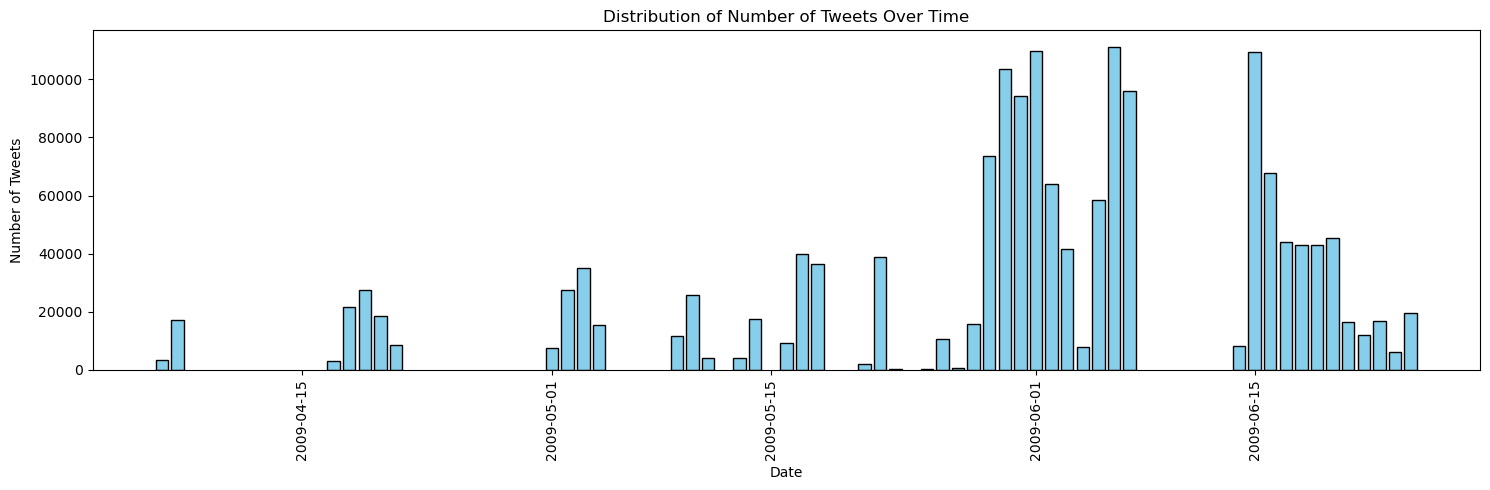

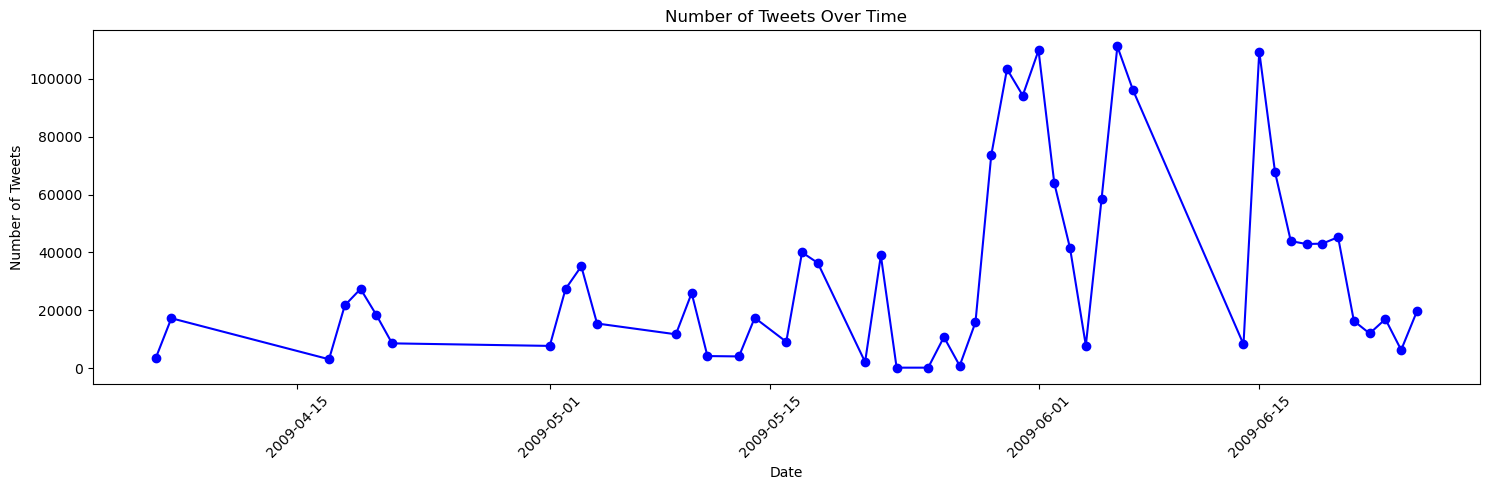

In [57]:
# Convert Spark DataFrame to Pandas DataFrame for plotting
tweets_per_day_pd = tweets_per_day.toPandas()

# Sort the DataFrame based on the date for the line plot
tweets_per_day_pd.sort_values('daily_records', inplace=True)

# Plot the bar chart
plt.figure(figsize=(15, 5))
plt.bar(tweets_per_day_pd['daily_records'], tweets_per_day_pd['count'], color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Tweets Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=90)  # Rotate the dates for better readability if there are many bars
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

# Line plot of the number of tweets over time
plt.figure(figsize=(15, 5))
plt.plot(tweets_per_day_pd['daily_records'], tweets_per_day_pd['count'], marker='o', linestyle='-', color='blue')
plt.title('Number of Tweets Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()


# VISUALIZE THIS THROUGH TIMESERIES PLOT - LINEPLOT
# visualize also the  HISTOGRAM DISTRIBUTION 

In [29]:
# Number of rows
num_rows = tweets_per_day.count()

# Number of columns
num_columns = len(tweets_per_day.columns)

# Print out the shape
print(f"The DataFrame shape is: ({num_rows}, {num_columns})")

The DataFrame shape is: (48, 2)


- The last few codes shows that the number of tweets are not evenly spread between the days, but also there are periods with no tweets. Thus, the tweets column does not have a normal distribution regarind the number of tweets per day. 
- 47 days with tweets (the first row is the column name)

In [92]:
# Find the Minimum and Maximum Dates
min_date = tweets_per_day.agg(F.min("daily_records")).collect()[0][0]
max_date = tweets_per_day.agg(F.max("daily_records")).collect()[0][0]

# Calculate the Date Range
date_range = (max_date - min_date).days

# Print the Date Range
print(f"The range of days is: {date_range} days")

The range of days is: 80 days


The last code presented the number of gaps, but also the days that are missing tweets.
- 47 days with tweets;
- 33 days without tweets;

The period between the first and last day recorded represents a time interval of 80 days. 

In [30]:
# Add a new column 'text_length' that contains the length of the 'text' column.
df = df.withColumn("text_length", length(df.text))

# Add a new column 'word_count' that contains the number of words in the 'text' column.
df = df.withColumn("word_count", size(split(df.text, "\s+")))

df.select("text_length", "word_count").show()

+-----------+----------+
|text_length|word_count|
+-----------+----------+
|         28|         6|
|        123|        24|
|         29|         7|
|         82|        16|
|         37|        10|
|        119|        24|
|        111|        22|
|         29|         6|
|         57|        13|
|        118|        20|
|         34|         8|
|         91|        16|
|        128|        22|
|         17|         4|
|        124|        23|
|         67|        16|
|         37|         9|
|         60|        10|
|         56|        11|
|        102|        23|
+-----------+----------+
only showing top 20 rows



In [31]:
df.describe(["word_count", "text_length"]).show()

+-------+------------------+-----------------+
|summary|        word_count|      text_length|
+-------+------------------+-----------------+
|  count|           1595102|          1595102|
|   mean|13.599865713916728|  64.165568722251|
| stddev|6.7376460875575335|34.18022357508237|
|    min|                 1|                2|
|    max|                42|              179|
+-------+------------------+-----------------+



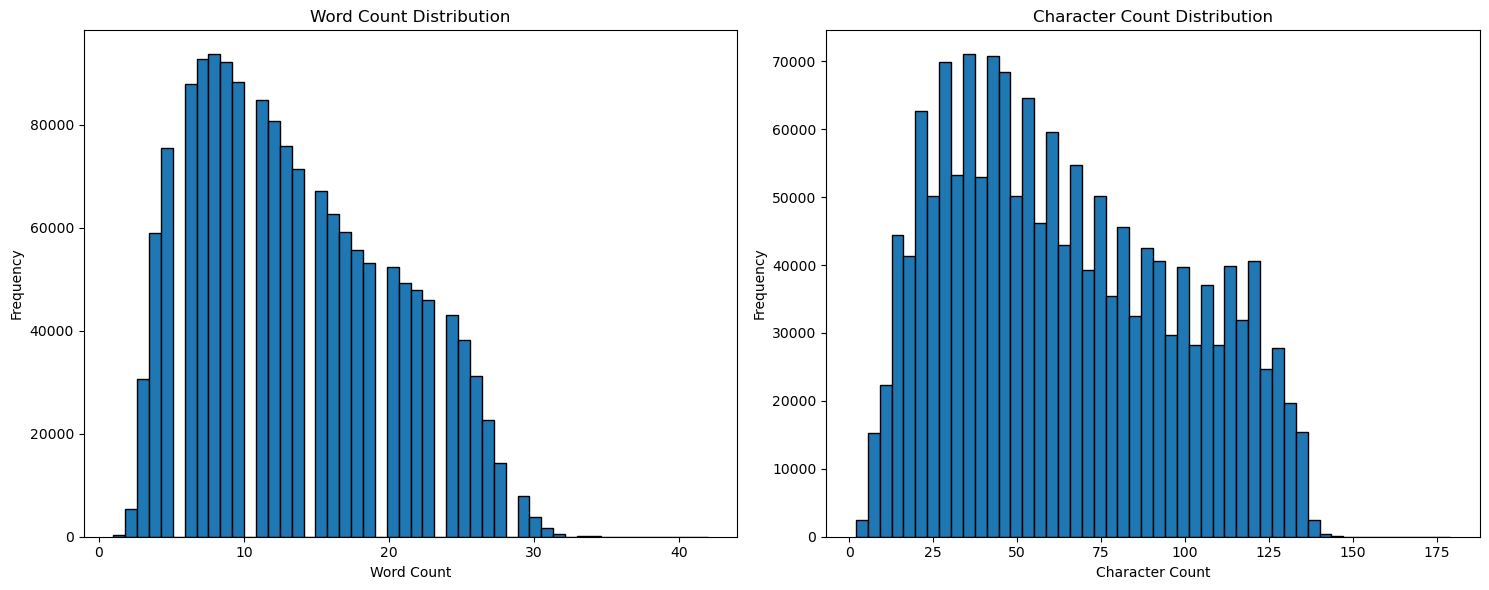

In [33]:
# Selects the word and char count columns
word_char_df = df.select("word_count", "text_length").toPandas()

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot Word Count Distribution
axes[0].hist(word_char_df['word_count'], bins=50, edgecolor='black')
axes[0].set_title('Word Count Distribution')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')

# Plot Character Count Distribution
axes[1].hist(word_char_df['text_length'], bins=50, edgecolor='black')
axes[1].set_title('Character Count Distribution')
axes[1].set_xlabel('Character Count')
axes[1].set_ylabel('Frequency')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

The descripte statistics and histograms of the word and character length informs that:

- Word count:
1. The shortest tweet has 1 word and the longest has 42.
2. The average of words per tweet is 13.6 and the StdDev is 6.75, indicating that there are significant amount of tweets around the mean. Also, informs that the number of words does not present a high variability between data points.
3. The distribution plot shows that the majority of tweets are composed by 20 or less words. 
4. There are also longer tweets but they are less frequent, making the word count slightly right-skewed. 

- Character count: 
1. The shortest tweet has 2 char and the longest has 179. (Not surpassing the maximum amount of characters set by twitter at this time, which is 280).
2. The average of character in each tweet is 64, with a standard deviation of 34. Meaning that the based on the avg value the stddev is high (34), indicating that the data points are more spread out.

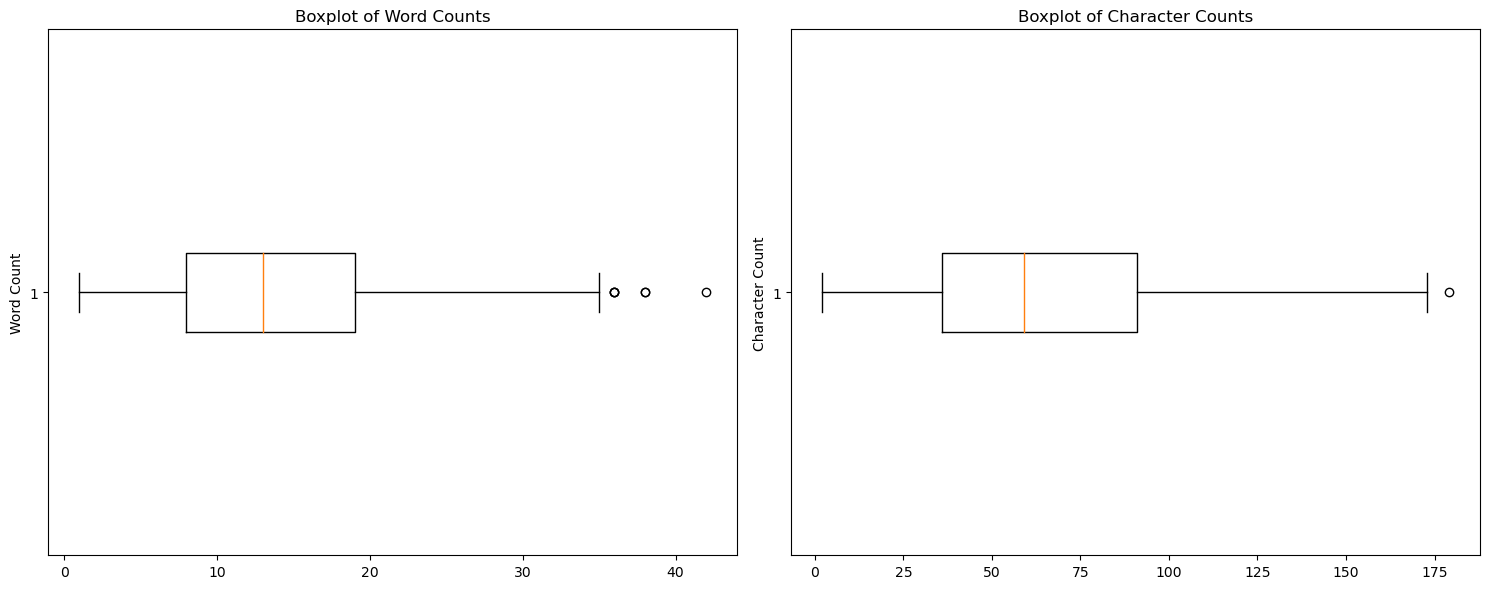

In [35]:
# Creates a figure with two subplots side by side for boxplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot Boxplot for Word Count
axes[0].boxplot(word_char_df['word_count'], vert=False)
axes[0].set_title('Boxplot of Word Counts')
axes[0].set_ylabel('Word Count')

# Plot Boxplot for Character Count
axes[1].boxplot(word_char_df['text_length'], vert=False)
axes[1].set_title('Boxplot of Character Counts')
axes[1].set_ylabel('Character Count')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

- The boxplots of the number of character and words indicated the presence of outliers. However, they are a valid data point, therefore the ourliers will be used in the projects. 
- The next step will perform an aggregation to obtain the daily average of tweets word and characters count.

In [37]:
# Extract the daily records and the word count
daily_word_count = df.groupBy("daily_records") \
    .agg(F.avg("word_count").alias("average_word_count"))

# Show the resulting DataFrame
daily_word_count.show()

+-------------+------------------+
|daily_records|average_word_count|
+-------------+------------------+
|   2009-05-13|13.517385943279901|
|   2009-06-25|14.155266236077912|
|   2009-05-01|13.502405408919516|
|   2009-06-15|13.517517654689799|
|   2009-06-07| 13.37701929987189|
|   2009-05-03|13.527716249219061|
|   2009-06-24|14.069212410501194|
|   2009-05-11|13.657252273815223|
|   2009-05-27|13.224611708482676|
|   2009-04-17|13.540637191157348|
|   2009-06-20|13.933439335718386|
|   2009-04-20|13.646291768541158|
|   2009-06-22|14.025946938094444|
|   2009-04-21| 13.78149790013999|
|   2009-05-23|13.680473372781066|
|   2009-05-25|13.911242603550296|
|   2009-06-01|13.590260331330784|
|   2009-04-19| 13.41344820033584|
|   2009-05-18|13.680515838099428|
|   2009-06-21|13.944080357689716|
+-------------+------------------+
only showing top 20 rows



In [38]:
# Creates a df with the daily average for the char count. 
daily_character_count = df.groupBy("daily_records") \
    .agg(F.avg("text_length").alias("average_character_count")) \
    .orderBy("daily_records")

# Show the resulting DataFrame
daily_character_count.show()

+-------------+-----------------------+
|daily_records|average_character_count|
+-------------+-----------------------+
|   2009-04-06|      64.73397243858598|
|   2009-04-07|      65.22715419829635|
|   2009-04-17|      64.03836150845254|
|   2009-04-18|     63.206554807780954|
|   2009-04-19|      63.39782434109659|
|   2009-04-20|      64.69926650366749|
|   2009-04-21|      65.30121325244984|
|   2009-05-01|     63.832531530360164|
|   2009-05-02|      64.19498556339315|
|   2009-05-03|      63.88851025160447|
|   2009-05-04|      64.22819748606972|
|   2009-05-09|      62.71328492097394|
|   2009-05-10|      64.25258208725143|
|   2009-05-11|      64.36141694590714|
|   2009-05-13|      64.40887792848335|
|   2009-05-14|          65.1201171875|
|   2009-05-16|      62.78132543339917|
|   2009-05-17|      63.61345524494741|
|   2009-05-18|      64.95430048394192|
|   2009-05-21|      63.88024516737388|
+-------------+-----------------------+
only showing top 20 rows



Also based on the distribution plot where most of the tweets are allocated between word level (5-15) and char level (50-65), the resulted daily averages falls under the expected range. However, a similiar average was not expected.  

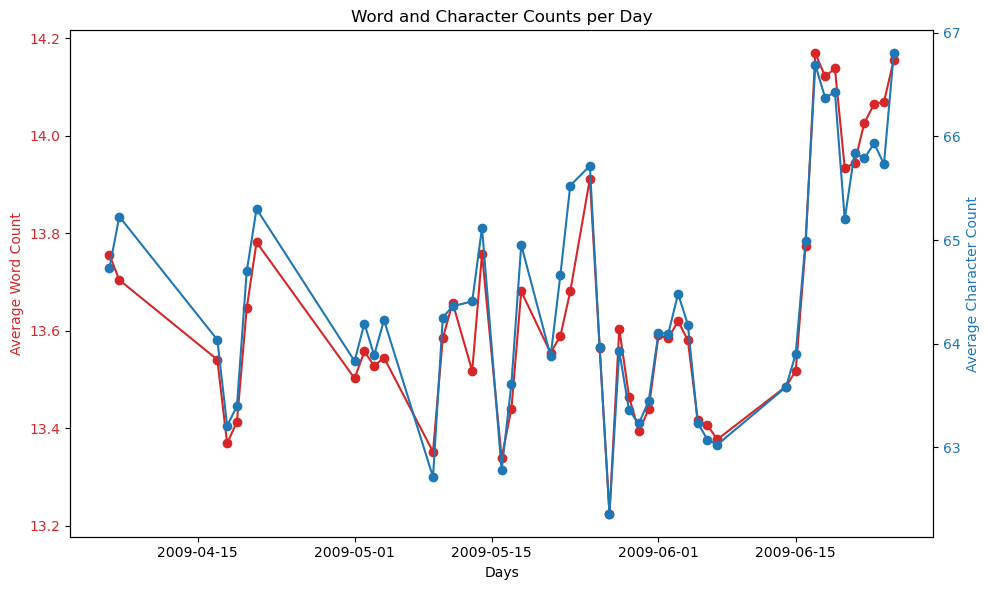

In [39]:
# Convert to Pandas DataFrames
daily_word_count_pd = daily_word_count.toPandas()
daily_character_count_pd = daily_character_count.toPandas()

# Sort Pandas DataFrames by 'daily_records'
daily_word_count_pd = daily_word_count_pd.sort_values('daily_records')
daily_character_count_pd = daily_character_count_pd.sort_values('daily_records')

# Plotting the graph
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Days')
ax1.set_ylabel('Average Word Count', color=color)
ax1.plot(daily_word_count_pd['daily_records'], daily_word_count_pd['average_word_count'], color=color, marker='o', label='Average Word Count')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average Character Count', color=color)
ax2.plot(daily_character_count_pd['daily_records'], daily_character_count_pd['average_character_count'], color=color, marker='o', label='Average Character Count')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Word and Character Counts per Day')
plt.tight_layout()
plt.show()

- The line plot with the word and character count per day follow the logical where the number of characters tend to follow the number of words. 
- Only a few days where user posted longer tweets but with less characters.

# EDA Sentiment Label and Scores

In [ ]:
# Calculate the total number of tweets
total_count = df.count()

# Group by the 'sentiment' column and count the occurrences
frequency_df = df.groupBy("sentiment_score").count()

# Show the result
frequency_percent_df.show()

In [43]:
df.describe("sentiment_score").show()

+-------+-------------------+
|summary|    sentiment_score|
+-------+-------------------+
|  count|            1595102|
|   mean|0.09431980588075202|
| stddev|  0.929098211973541|
|    min|               -1.0|
|    max|                1.0|
+-------+-------------------+



In [47]:
from pyspark.sql.functions import when
# Defines bin ranges.
bin_ranges = [-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Creates a new column for the bins.
# Creates bin conditions using a function.
bin_conditions = when(df.sentiment_score <= bin_ranges[0], str(bin_ranges[0]))
for i in range(1, len(bin_ranges)):
    bin_conditions = bin_conditions.when((df.sentiment_score > bin_ranges[i - 1]) & (df.sentiment_score <= bin_ranges[i]), str(bin_ranges[i]))

# Adds a default case if needed.
bin_conditions = bin_conditions.otherwise(str(bin_ranges[-1]))

# Apply the binning.
df_with_bins = df.select("sentiment_score").withColumn("score_bin", bin_conditions)

# Group by the bins and the count.
histogram_data = df_with_bins.groupBy("score_bin").count().collect()

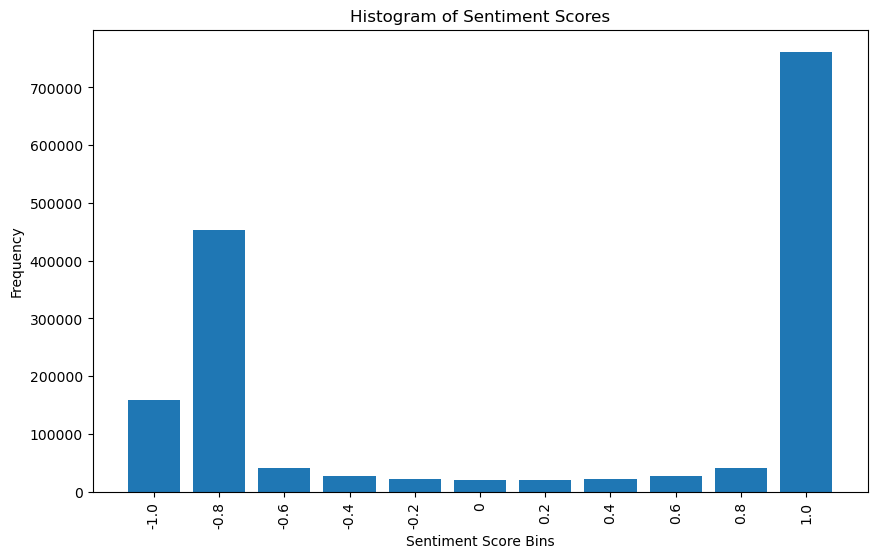

In [50]:
# Convert the score_bin from a range string to the lower bound for sorting
histogram_data_sorted = sorted(histogram_data, key=lambda x: float(x['score_bin'].split(' to ')[0]))

# Now extract the bins and counts again, which should be sorted
bins_sorted = [row['score_bin'] for row in histogram_data_sorted]
counts_sorted = [row['count'] for row in histogram_data_sorted]

# Plot the histogram with the sorted bins
plt.figure(figsize=(10, 6))
plt.bar(range(len(counts_sorted)), counts_sorted, align='center')  # Use numerical x-axis
plt.xticks(range(len(bins_sorted)), bins_sorted, rotation=90)  # Add bin labels as x-tick labels
plt.xlabel('Sentiment Score Bins')
plt.ylabel('Frequency')
plt.title('Histogram of Sentiment Scores')
plt.show()


- The range of the scores are between -1 and 1.
- From the previous codes, the sentiment scores have the average of 0.09, which is right in the middle between the min and max range of the scores. This can be investigated by looking at the histogram where it shows that most of the values are located at the extremes (Bimodal distribution) and because of the mathematical operation the average will tend to the center. 
- Due to its characteristics the distribution do not present any skewness, but rather a big difference between extreme "opinions" and neutral tweets.  
<br><br>
Next step will aggregate tho generate the overall sentment of the day. 

In [52]:
# Calculate the median sentiment score for each day
daily_median_sentiment = df.groupBy('daily_records').agg(F.expr('percentile_approx(sentiment_score, 0.5)').alias('median_sentiment'))

daily_median_sentiment.show()

+-------------+----------------+
|daily_records|median_sentiment|
+-------------+----------------+
|   2009-05-13|           0.725|
|   2009-06-25|          -0.706|
|   2009-05-01|           0.757|
|   2009-06-15|           0.716|
|   2009-06-07|           0.827|
|   2009-05-03|           0.753|
|   2009-06-24|          -0.588|
|   2009-05-11|            0.61|
|   2009-05-27|            0.52|
|   2009-04-17|            0.83|
|   2009-06-20|          -0.592|
|   2009-04-20|           0.742|
|   2009-06-22|          -0.557|
|   2009-04-21|           0.744|
|   2009-05-23|           0.785|
|   2009-05-25|           0.956|
|   2009-06-01|           0.734|
|   2009-04-19|           0.803|
|   2009-05-18|           0.767|
|   2009-06-21|          -0.526|
+-------------+----------------+
only showing top 20 rows



In [51]:
# For weighted average, calculate the mean sentiment and count of tweets for each day
daily_sentiment = df.select("sequence", "sentiment_score", "daily_records").groupBy('daily_records').agg(
    F.avg('sentiment_score').alias('average_sentiment'),
    F.count('sequence').alias('tweet_count')
)

# Add a normalized weight for each day based on tweet count
max_tweets = daily_sentiment.agg(F.max('tweet_count')).first()[0]
daily_sentiment = daily_sentiment.withColumn('weight', F.col('tweet_count') / max_tweets)

# Calculate the weighted average sentiment
weighted_average_sentiment = daily_sentiment.withColumn('weighted_sentiment', F.col('weight') * F.col('average_sentiment'))

weighted_average_sentiment.show()

+-------------+--------------------+-----------+--------------------+--------------------+
|daily_records|   average_sentiment|tweet_count|              weight|  weighted_sentiment|
+-------------+--------------------+-----------+--------------------+--------------------+
|   2009-05-13| 0.11090974106041925|       4055| 0.03645337025117316|0.004043033855337205|
|   2009-06-25|-0.11885856685144695|      19663|  0.1767651342167245|-0.02101005052230354|
|   2009-05-01| 0.12633701729293978|       7691| 0.06914004207195383|0.008734946690879016|
|   2009-06-15| 0.11275591306492726|     109461|  0.9840252431722972| 0.11095466477282945|
|   2009-06-07| 0.14326315734655404|      96011|  0.8631133245833258| 0.12365234002768836|
|   2009-05-03| 0.12341293235644918|      35214| 0.31656448336000287|0.039068151171362316|
|   2009-06-24|-0.09146634844868731|       6285| 0.05650047645588738|-0.00516789226703...|
|   2009-05-11| 0.09436811871708949|       4178| 0.03755910749923587|0.003544382315395...|

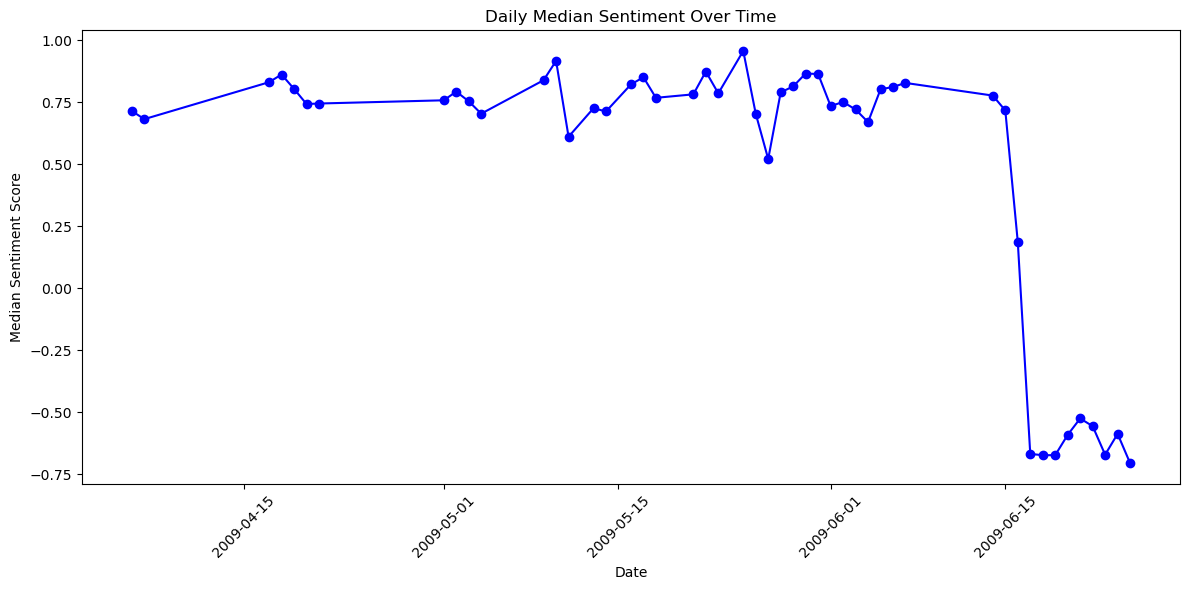

In [53]:
# Collect the data to the local environment
daily_median_sentiment_data = daily_median_sentiment.sort('daily_records').collect()

# Extract dates and median sentiments for plotting
dates = [row['daily_records'] for row in daily_median_sentiment_data]
median_sentiments = [row['median_sentiment'] for row in daily_median_sentiment_data]

# Collect the data to the local environment
weighted_average_sentiment_data = weighted_average_sentiment.sort('daily_records').collect()

# Extract dates and weighted average sentiments for plotting
dates = [row['daily_records'] for row in weighted_average_sentiment_data]
weighted_avg_sentiments = [row['weighted_sentiment'] for row in weighted_average_sentiment_data]
avg_sentiments = [row['average_sentiment'] for row in weighted_average_sentiment_data]

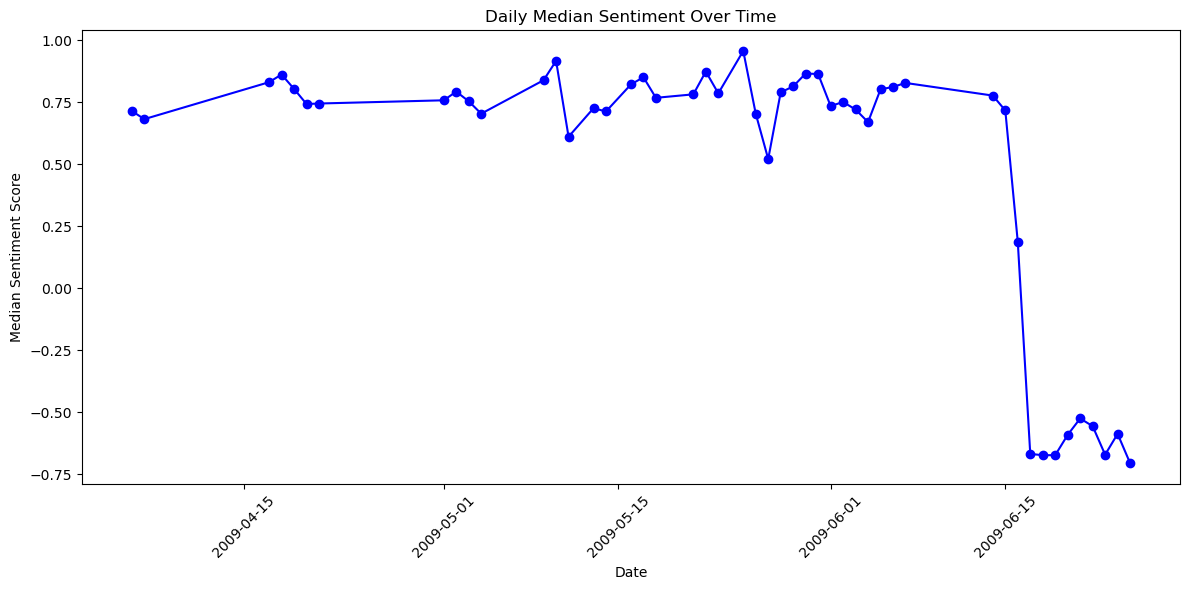

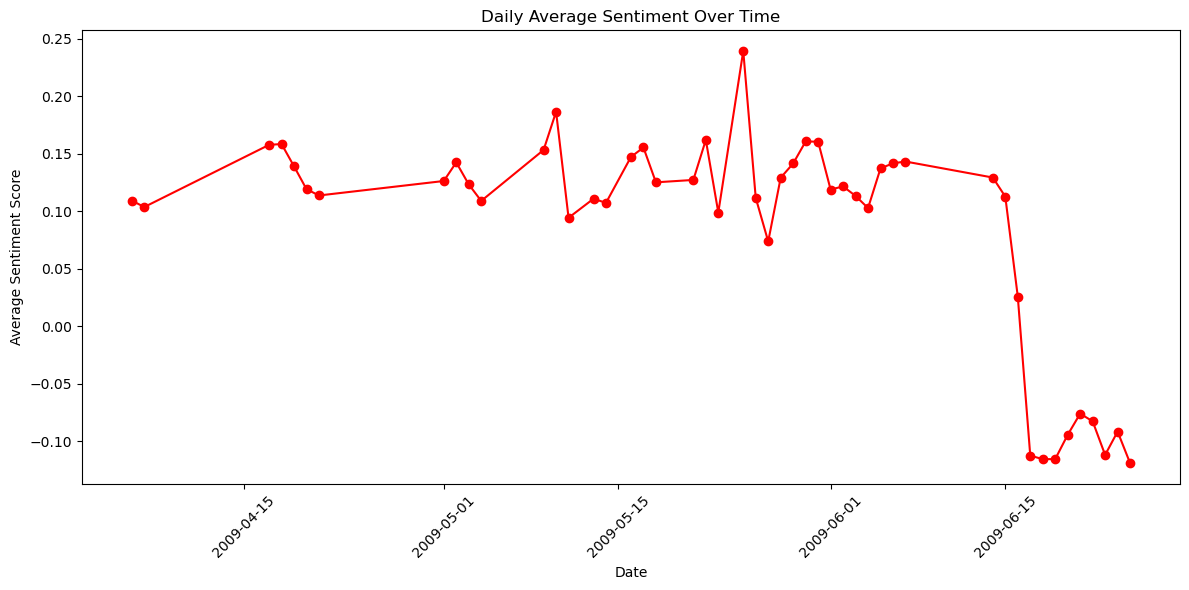

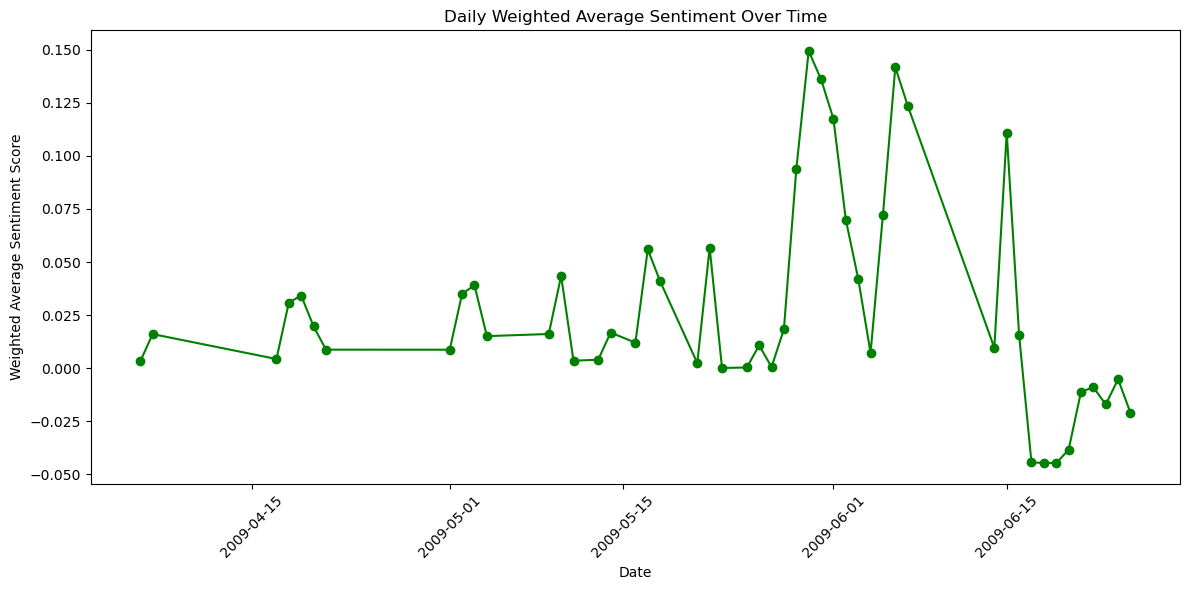

In [61]:
# Now plot the time series
plt.figure(figsize=(12, 6))
plt.plot(dates, median_sentiments, marker='o', linestyle='-', color='blue')
plt.title('Daily Median Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Median Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

# Now plot the time series
plt.figure(figsize=(12, 6))
plt.plot(dates, avg_sentiments, marker='o', linestyle='-', color='red')
plt.title('Daily Average Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

# Now plot the time series
plt.figure(figsize=(12, 6))
plt.plot(dates, weighted_avg_sentiments, marker='o', linestyle='-', color='green')
plt.title('Daily Weighted Average Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Weighted Average Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

- By aggregating using the average and the median yielded similar pattern, although having different scales.
- By aggregating using the weighted average, because of the the difference between the number of tweets per day, resulted in a similar pattern as the volume. Thus, the polarity of sentiments get stronger when the number of tweets increases, 

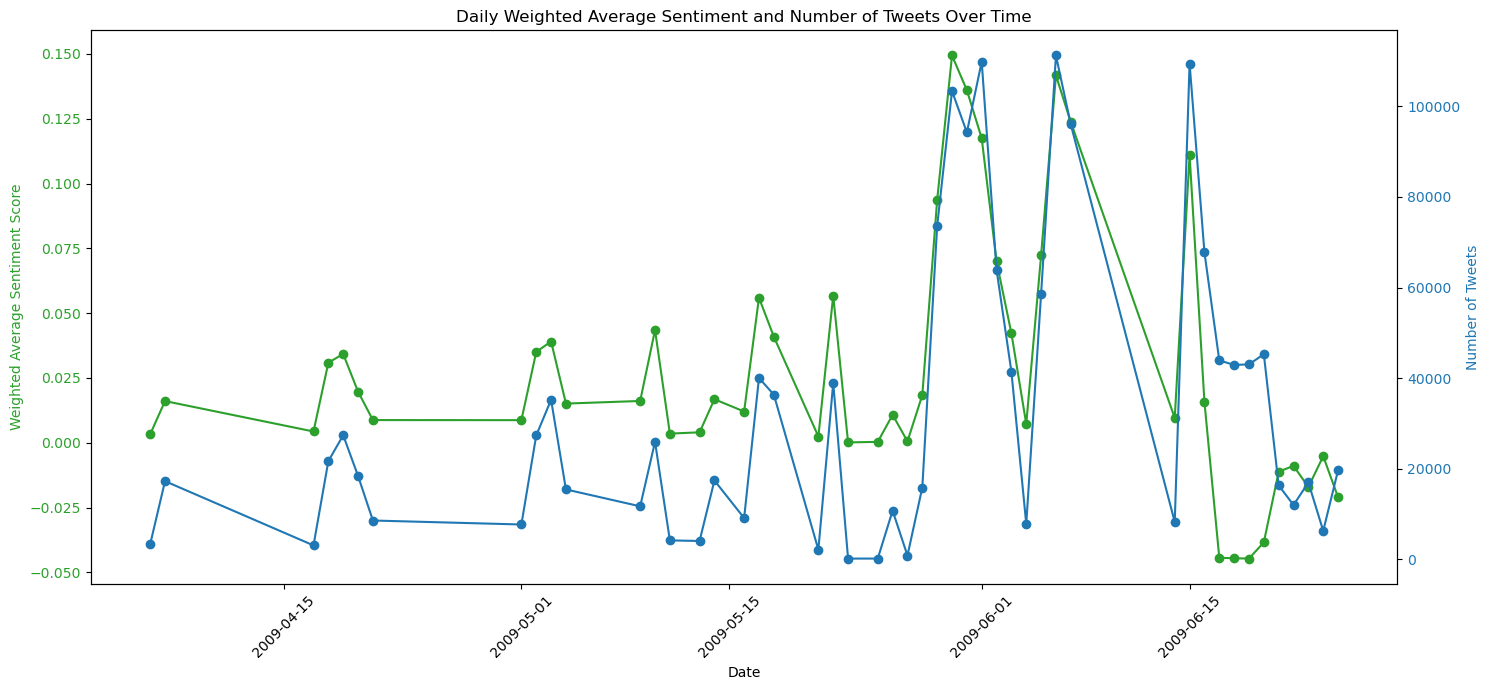

In [58]:
# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot the weighted average sentiment over time on the primary y-axis
color = 'tab:green'
ax1.set_xlabel('Date')
ax1.set_ylabel('Weighted Average Sentiment Score', color=color)
ax1.plot(dates, weighted_avg_sentiments, marker='o', linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)

# Instantiate a second y-axis, sharing the same x-axis
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Number of Tweets', color=color)  
ax2.plot(tweets_per_day_pd['daily_records'], tweets_per_day_pd['count'], marker='o', linestyle='-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Daily Weighted Average Sentiment and Number of Tweets Over Time')
fig.tight_layout()  # Adjust the plot to ensure everything fits without overlapping

plt.show()

- The last cell generated a figure that shows the behaviour of sentiment scores and volume of tweets overtime, pointing that during this period

add missing values with rolling weighted avg

# TIME SERIES ANALYSIS USING THE SENTIMENT SCORE AND TWEETS USING THE DATECOLUMN AS TIMESTAMP

In [67]:
df_daily_sent = weighted_average_sentiment.drop("average_sentiment", "tweet_count")

# Reducing the precision to three decimals can keep the precision and at the same making the column more memory friendly.
df_daily_sent = df_daily_sent.withColumn("weighted_sentiment", round(df_daily_sent["weighted_sentiment"], 3))
df_daily_sent = df_daily_sent.withColumn("weight", round(df_daily_sent["weight"], 5))

df_daily_sent.show()

+-------------+-------+------------------+
|daily_records| weight|weighted_sentiment|
+-------------+-------+------------------+
|   2009-05-13|0.03645|             0.004|
|   2009-06-25|0.17677|            -0.021|
|   2009-05-01|0.06914|             0.009|
|   2009-06-15|0.98403|             0.111|
|   2009-06-07|0.86311|             0.124|
|   2009-05-03|0.31656|             0.039|
|   2009-06-24| 0.0565|            -0.005|
|   2009-05-11|0.03756|             0.004|
|   2009-05-27|0.00752|             0.001|
|   2009-04-17|0.02765|             0.004|
|   2009-06-20|0.40707|            -0.038|
|   2009-04-20|0.16546|              0.02|
|   2009-06-22|0.10775|            -0.009|
|   2009-04-21|0.07706|             0.009|
|   2009-05-23|0.00152|               0.0|
|   2009-05-25|0.00152|               0.0|
|   2009-06-01|0.98761|             0.117|
|   2009-04-19|0.24626|             0.034|
|   2009-05-18|0.32694|             0.041|
|   2009-06-21|0.14678|            -0.011|
+----------

In [71]:
# Calculate the minimum and maximum dates using fully qualified function names
min_max_dates = df_daily_sent.agg(F.min("daily_records").alias("start_date"), 
                       F.max("daily_records").alias("end_date")).collect()
start_date, end_date = min_max_dates[0]['start_date'], min_max_dates[0]['end_date']

# Print the start and end dates
print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")

Start Date: 2009-04-06
End Date: 2009-06-25


In [87]:
from pyspark.sql.functions import explode, sequence, to_date, lit

# Create a DataFrame with a range of dates
date_df = spark.sql("SELECT explode(sequence(to_date('2009-04-06'), to_date('2009-06-25'), interval 1 day)) as daily_records")
date_df.show()

+-------------+
|daily_records|
+-------------+
|   2009-04-06|
|   2009-04-07|
|   2009-04-08|
|   2009-04-09|
|   2009-04-10|
|   2009-04-11|
|   2009-04-12|
|   2009-04-13|
|   2009-04-14|
|   2009-04-15|
|   2009-04-16|
|   2009-04-17|
|   2009-04-18|
|   2009-04-19|
|   2009-04-20|
|   2009-04-21|
|   2009-04-22|
|   2009-04-23|
|   2009-04-24|
|   2009-04-25|
+-------------+
only showing top 20 rows



In [88]:
# Join with the existing DataFrame
result_df = date_df.join(df_daily_sent, "daily_records", "left_outer")

# Show the result
result_df.show()

+-------------+-------+------------------+
|daily_records| weight|weighted_sentiment|
+-------------+-------+------------------+
|   2009-04-11|   null|              null|
|   2009-04-17|0.02765|             0.004|
|   2009-04-20|0.16546|              0.02|
|   2009-04-15|   null|              null|
|   2009-04-16|   null|              null|
|   2009-04-13|   null|              null|
|   2009-04-21|0.07706|             0.009|
|   2009-04-19|0.24626|             0.034|
|   2009-04-25|   null|              null|
|   2009-04-14|   null|              null|
|   2009-04-26|   null|              null|
|   2009-04-07|0.15514|             0.016|
|   2009-04-08|   null|              null|
|   2009-04-18|0.19502|             0.031|
|   2009-04-22|   null|              null|
|   2009-04-24|   null|              null|
|   2009-04-06|0.03001|             0.003|
|   2009-04-12|   null|              null|
|   2009-04-23|   null|              null|
|   2009-04-09|   null|              null|
+----------

In [91]:
# Calculate the minimum and maximum dates using fully qualified function names
min_max_dates = result_df.agg(F.min("daily_records").alias("start_date"), 
                       F.max("daily_records").alias("end_date")).collect()
start_date, end_date = min_max_dates[0]['start_date'], min_max_dates[0]['end_date']

# Print the start and end dates
print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")

Start Date: 2009-04-06
End Date: 2009-06-25


In [90]:
# Find the count of missing values in the 'text' column
missing_values_count = result_df.filter(result_df.weighted_sentiment.isNull()).count()
print(f"Number of missing values in 'text' column: {missing_values_count}")

Number of missing values in 'text' column: 33


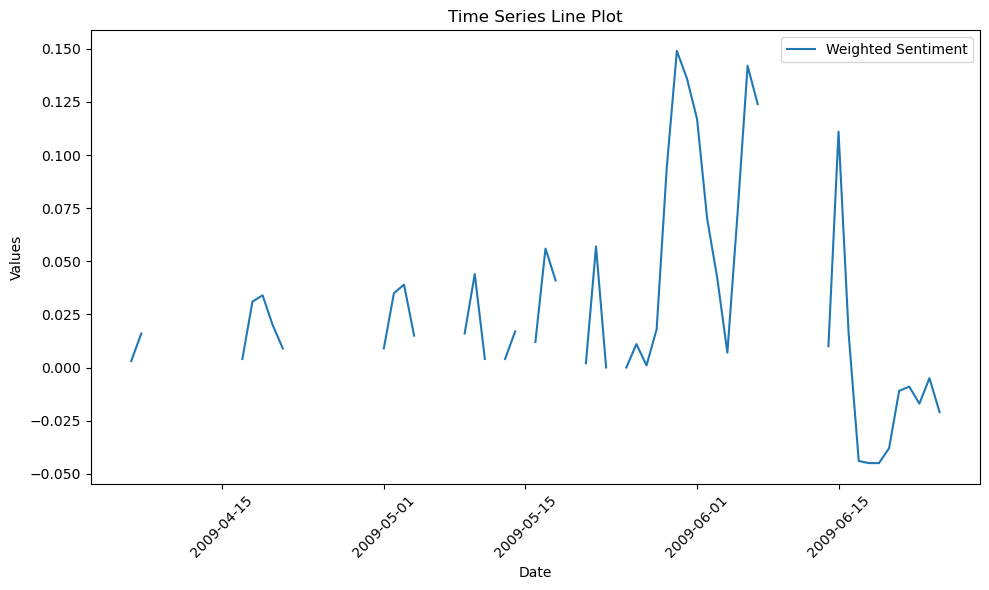

In [95]:
# Order the DataFrame by date
result_df = result_df.orderBy("daily_records")

# Convert to Pandas DataFrame for plotting
pandas_df = result_df.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(pandas_df['daily_records'], pandas_df['weighted_sentiment'], label='Weighted Sentiment')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series Line Plot')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [197]:
# Reset the index
pandas_df.reset_index(inplace=True)

# Convert to Pandas DataFrame for plotting
df_og = result_df.toPandas()

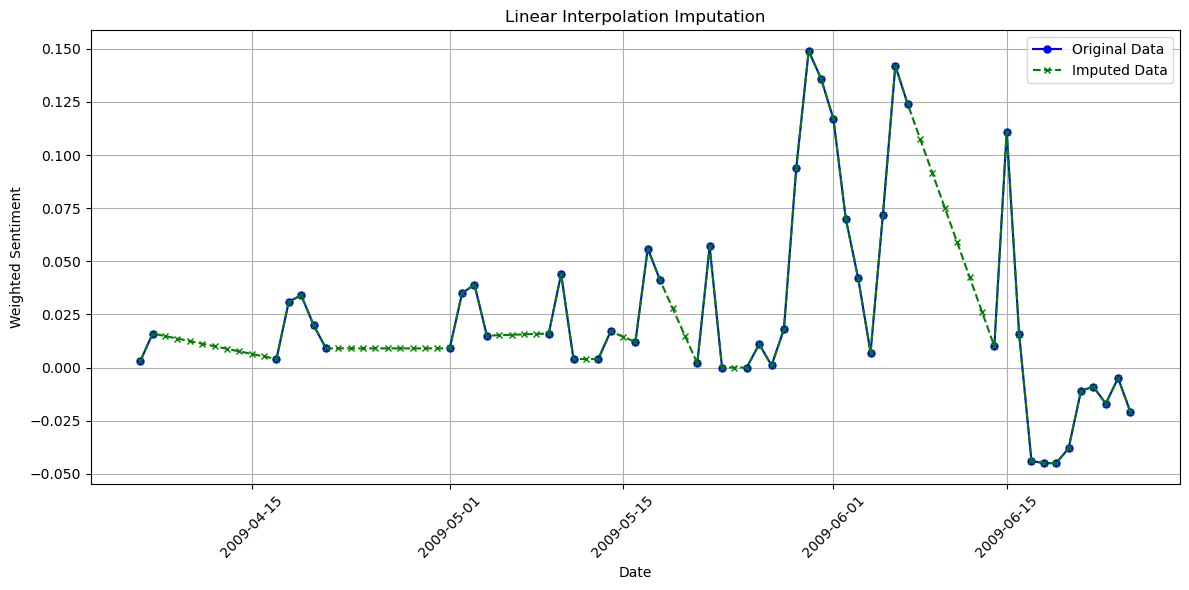

In [176]:
# Perform linear interpolation
pandas_df['weighted_sentiment'].interpolate(method='linear', inplace=True)

# Plot the original and imputed data with different markers and colors
plt.figure(figsize=(12, 6))
plt.plot(df_og['daily_records'], df_og['weighted_sentiment'], label='Original Data', marker='o', markersize=5, color='blue')
plt.plot(pandas_df['daily_records'], pandas_df['imputed_weighted_sentiment'], label='Imputed Data', linestyle='--', marker='x', markersize=5, color='green')
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.title('Linear Interpolation Imputation')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [155]:
def ema_imputation(series, alpha):
    imputed_series = series.copy()
    missing_indices = series.isnull()
    
    for i in range(len(series)):
        if missing_indices[i]:
            if i == 0:
                imputed_series[i] = series[i]
            else:
                imputed_series[i] = alpha * series[i] + (1 - alpha) * imputed_series[i - 1]
    
    return imputed_series


In [157]:
# Choose the alpha value (smoothing factor)
alpha = 0.2  

# Apply EMA imputation to the 'weighted_sentiment' column
pandas_df3['imputed_weighted_sentiment'] = ema_imputation(pandas_df3['weighted_sentiment'], alpha)

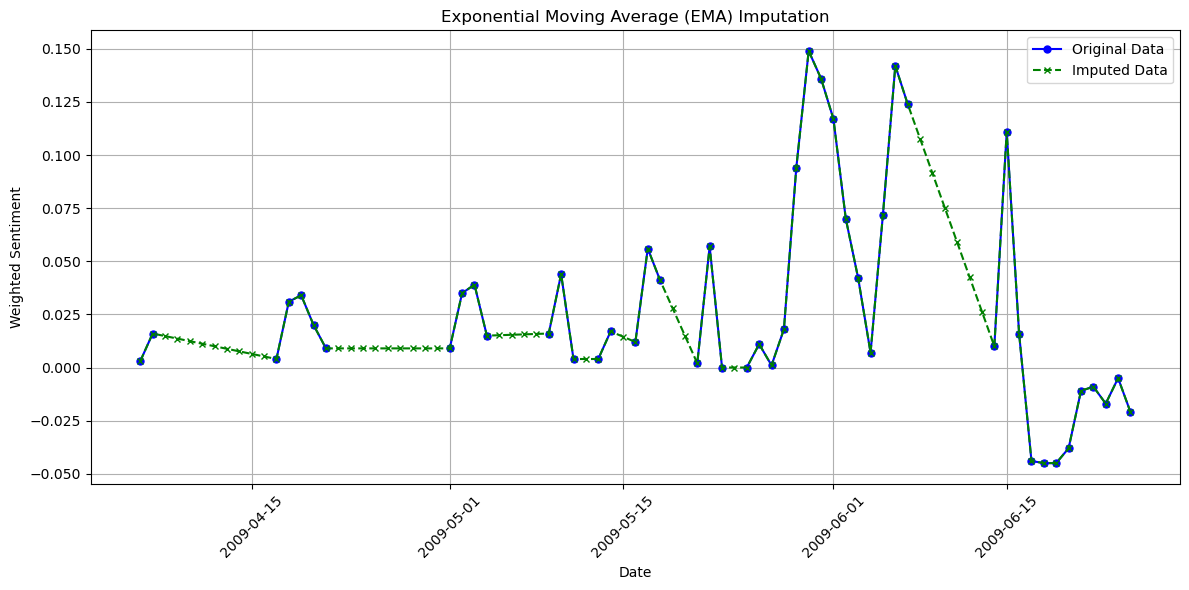

In [177]:
# Plot the original and imputed data with different markers and colors
plt.figure(figsize=(12, 6))
plt.plot(df_og['daily_records'], df_og['weighted_sentiment'], label='Original Data', marker='o', markersize=5, color='blue')
plt.plot(pandas_df3['daily_records'], pandas_df3['imputed_weighted_sentiment'], label='Imputed Data', linestyle='--', marker='x', markersize=5, color='green')
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.title('Exponential Moving Average (EMA) Imputation alpha = 0.2')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [179]:
# Choose the alpha value (smoothing factor)
alpha = 0.1  

# Apply EMA imputation to the 'weighted_sentiment' column
pandas_df2['imputed_weighted_sentiment'] = ema_imputation(pandas_df2['weighted_sentiment'], alpha)

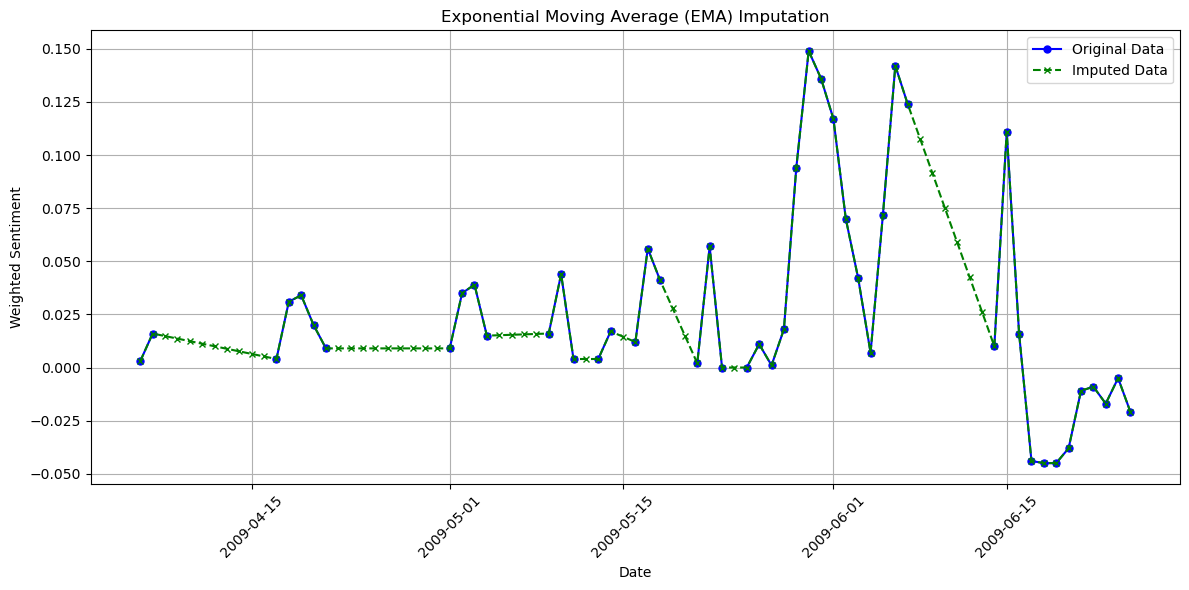

In [185]:
# Plot the original and imputed data with different markers and colors
plt.figure(figsize=(12, 6))
plt.plot(df_og['daily_records'], df_og['weighted_sentiment'], label='Original Data', marker='o', markersize=5, color='blue')
plt.plot(pandas_df2['daily_records'], pandas_df2['imputed_weighted_sentiment'], label='Imputed Data', linestyle='--', marker='x', markersize=5, color='green')
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.title('Exponential Moving Average (EMA) Imputation')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [207]:
pandas_df4 = df_og

In [208]:
pandas_df5 = df_og

In [ ]:
AAAA

In [ ]:
df.unpersist()

In [ ]:
# Write the DataFrame to a CSV file in the local file system of the Spark driver node
df.write.csv('file:///home/hduser/Desktop/CA2/pro_tweets.csv', header=True)